In [1]:
%cd ..

c:\Users\nakag\c3\pbl-ssc_with_gfootball


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
base_dir = './outputs/initial'

result_df = pd.read_csv(os.path.join(base_dir, 'results_1459164.csv'))
shoot_df = pd.read_csv(os.path.join(base_dir, 'shoots_1459164.csv'))

In [4]:
result_df

,frame_id,chance_team,winner,shoots,step_count,n_iter,n_sub_iter
0,1459164,Away,Draw,0,140,1,1
1,1459164,Away,Home,0,421,1,2
2,1459164,Away,Home,0,118,1,3
3,1459164,Away,Draw,0,207,1,4
4,1459164,Away,Draw,0,501,1,5
...,...,...,...,...,...,...,...
9995,1459164,Away,Draw,5,183,100,96
9996,1459164,Away,Draw,6,302,100,97
9997,1459164,Away,Draw,0,501,100,98
9998,1459164,Away,Draw,0,501,100,99


In [5]:
shoot_df

,frame_id,n_iter,n_sub_iter,shoot_x,shoot_y,shoot_direction_x,shoot_direction_y,ball_owned_team,ball_owned_player
0,1459164,1,10,0.744358,-0.194286,0.003551,0.002162,0,9
1,1459164,1,10,0.747822,-0.192166,0.003232,0.002009,0,9
2,1459164,1,10,0.750991,-0.190195,0.003125,0.001943,0,9
3,1459164,1,10,0.754003,-0.188322,0.002927,0.001820,0,9
4,1459164,1,10,0.805666,-0.141532,0.006667,0.004307,0,8
...,...,...,...,...,...,...,...,...,...
15431,1459164,100,97,-0.530681,-0.012031,-0.015718,0.000632,1,9
15432,1459164,100,97,-0.546289,-0.011404,-0.015518,0.000623,1,9
15433,1459164,100,97,-0.560688,-0.010826,-0.014020,0.000562,1,9
15434,1459164,100,97,-0.574317,-0.010279,-0.013088,0.000525,1,9


In [6]:
result_df['is_win'] = result_df['chance_team'] == result_df['winner']
shoot_df['shoot_y'] *= -1
shoot_df['shoot_direction_y'] *= -1

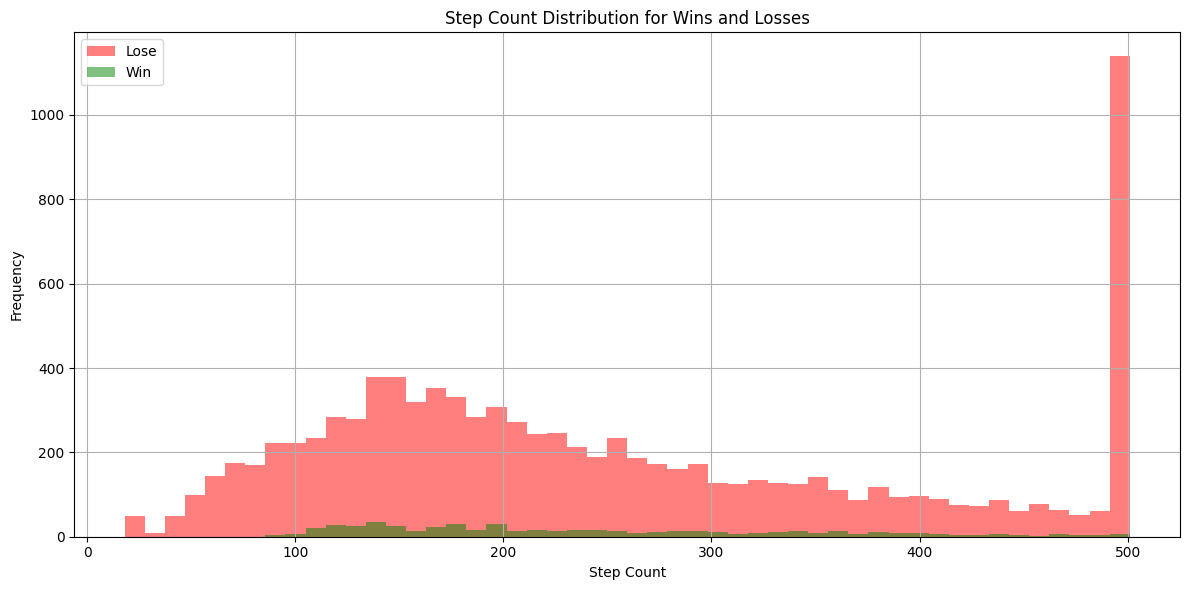

In [7]:
min_step = result_df['step_count'].min()
max_step = result_df['step_count'].max()

# 共通のビンの境界を生成
n_bins = 50
common_bins = np.linspace(min_step, max_step, n_bins + 1) # ビン数+1の値を指定

fig, ax = plt.subplots(figsize=(12, 6))

# Loseのヒストグラム
result_df.loc[~result_df['is_win'], 'step_count'].hist(
    bins=common_bins, ax=ax, alpha=0.5, label='Lose', color='red'
)

# Winのヒストグラム
result_df.loc[result_df['is_win'], 'step_count'].hist(
    bins=common_bins, ax=ax, alpha=0.5, label='Win', color='green'
)

ax.set_title('Step Count Distribution for Wins and Losses')
ax.set_xlabel('Step Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

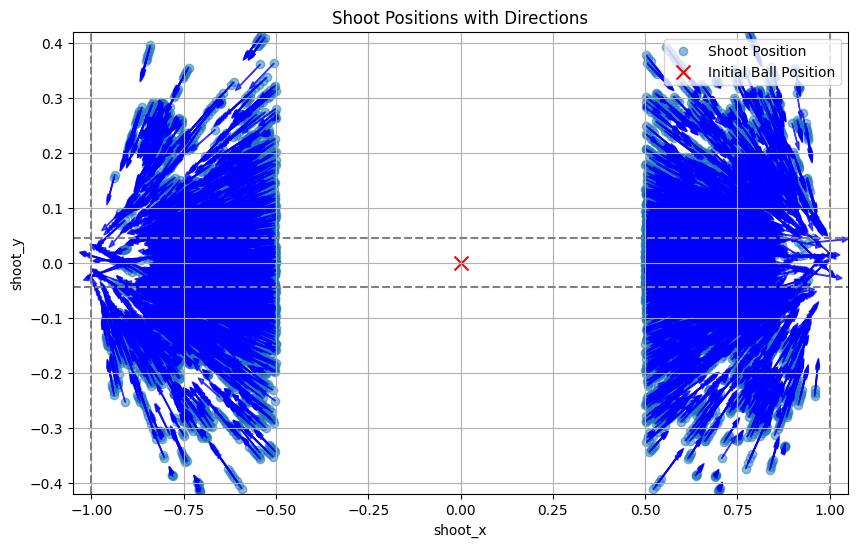

In [8]:
scale_factor = 10 # 矢印の長さを調整する係数
plt.figure(figsize=(10, 6))

# ゴールはx = -1,1 -0.044 < y < 0.044
plt.axvline(x=-1, color='gray', linestyle='--')
plt.axvline(x=1, color='gray', linestyle='--')
plt.axhline(y=0.044, color='gray', linestyle='--')
plt.axhline(y=-0.044, color='gray', linestyle='--')

# 散布図のプロット
plt.scatter(shoot_df['shoot_x'], shoot_df['shoot_y'], alpha=0.5, label='Shoot Position')

# 各点に対して方向を示す矢印を追加
for i, row in shoot_df.iterrows():
    x = row['shoot_x']
    y = row['shoot_y']
    dx = row['shoot_direction_x']
    dy = row['shoot_direction_y']

    plt.arrow(x, y, dx * scale_factor, dy * scale_factor,
              head_width=0.01, head_length=0.015, fc='blue', ec='blue',
              length_includes_head=True, alpha=0.7)

# SetBallPosition(-0.5689523809523809, -0.17182941176470595) plot as x
plt.scatter(0, 0, color='red', label='Initial Ball Position', s=100, marker='x')

plt.xlabel('shoot_x')
plt.ylabel('shoot_y')
plt.xlim(-1.05, 1.05)
plt.ylim(-0.42, 0.42)
plt.title('Shoot Positions with Directions')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

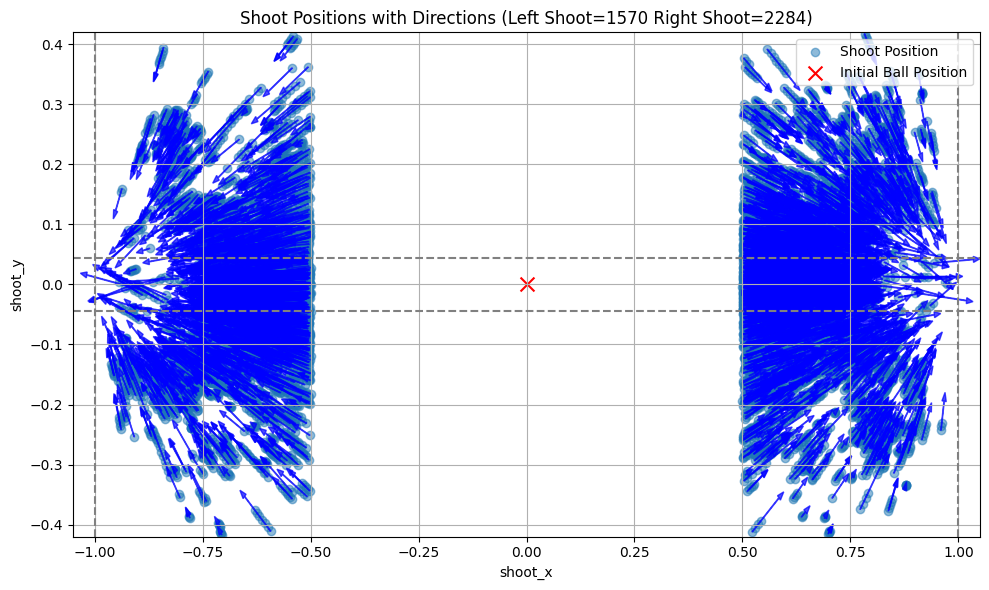

In [10]:
scale_factor = 10

# 同一直線上の矢印を除去するための許容誤差
tolerance_distance = 0.005 # 直線が同一とみなす距離の閾値
tolerance_angle = np.deg2rad(0.5) # 直線が同一とみなす角度の閾値 (ラジアン)

plt.figure(figsize=(10, 6))

# ゴールラインのプロット
plt.axvline(x=-1, color='gray', linestyle='--')
plt.axvline(x=1, color='gray', linestyle='--')
plt.axhline(y=0.044, color='gray', linestyle='--')
plt.axhline(y=-0.044, color='gray', linestyle='--')

# 散布図のプロット
plt.scatter(shoot_df['shoot_x'], shoot_df['shoot_y'], alpha=0.5, label='Shoot Position')

# 描画済みの直線の情報を格納するリスト
# 各要素は (unit_dx, unit_dy, c_value, n_iter_val, n_sub_iter_val) で構成される。
# 直線の方程式は Ax + By + C = 0 とし、A = -unit_dy, B = unit_dx, C = unit_dy * x - unit_dx * y である。
drawn_lines_info = []

# Left Shoot と Right Shoot のカウンター
left_shoot_count = 0
right_shoot_count = 0

# 各点に対して方向を示す矢印を追加（同一直線上のものを除去）
for i, row in shoot_df.iterrows():
    x = row['shoot_x']
    y = row['shoot_y']
    dx = row['shoot_direction_x']
    dy = row['shoot_direction_y']
    current_n_iter = row['n_iter']
    current_n_sub_iter = row['n_sub_iter']

    # 方向ベクトルの正規化
    norm_dir = np.sqrt(dx**2 + dy**2)
    if norm_dir == 0:
        continue # 方向ベクトルがゼロの場合はスキップ

    unit_dx = dx / norm_dir
    unit_dy = dy / norm_dir

    # 現在の矢印が定義する直線のC値を計算 (Ax + By + C = 0, where A=-unit_dy, B=unit_dx)
    current_c_value = unit_dy * x - unit_dx * y

    is_duplicate = False
    for p_unit_dx, p_unit_dy, p_c_value, p_n_iter, p_n_sub_iter in drawn_lines_info:
        # n_iter と n_sub_iter が同じである場合にのみ、空間的な重複を判定する
        if p_n_iter == current_n_iter and p_n_sub_iter == current_n_sub_iter:
            # 2直線の角度の差を計算 (ドット積を利用)
            dot_product = p_unit_dx * unit_dx + p_unit_dy * unit_dy
            
            # NaN防止のためクリップ
            dot_product = np.clip(dot_product, -1.0, 1.0) 
            
            angle_diff = np.arccos(dot_product)
            
            # 角度が非常に近い、または逆方向でも同一とみなす
            if angle_diff < tolerance_angle or abs(angle_diff - np.pi) < tolerance_angle:
                # 現在の矢印の始点から既存の直線への距離を計算
                # 点(x0, y0)から直線 Ax + By + C = 0 への距離は |Ax0 + By0 + C| / sqrt(A^2 + B^2)
                # ここで A = -p_unit_dy, B = p_unit_dx, sqrt(A^2 + B^2) = 1 (正規化済みのため)
                distance_to_line = abs((-p_unit_dy) * x + (p_unit_dx) * y + p_c_value)
                
                if distance_to_line < tolerance_distance:
                    is_duplicate = True
                    break
    
    if not is_duplicate:
        plt.arrow(x, y, dx * scale_factor, dy * scale_factor,
                  head_width=0.01, head_length=0.015, fc='blue', ec='blue',
                  length_includes_head=True, alpha=0.7)
        # 描画した矢印の直線の情報を追加（n_iterとn_sub_iterも含む）
        drawn_lines_info.append((unit_dx, unit_dy, current_c_value, current_n_iter, current_n_sub_iter))

        # Left Shoot / Right Shoot のカウント
        if x < -0.5:
            left_shoot_count += 1
        elif x > 0.5:
            right_shoot_count += 1

# Initial Ball Position をプロット (xの値は提供された値を使用し、yの値は反転させる)
initial_ball_x = 0
initial_ball_y = 0 * -1 # y値は反転させる
plt.scatter(initial_ball_x, initial_ball_y, color='red', label='Initial Ball Position', s=100, marker='x')

plt.xlabel('shoot_x')
plt.ylabel('shoot_y')
plt.xlim(-1.05, 1.05)
plt.ylim(-0.42, 0.42)
# タイトルにLeft ShootとRight Shootのカウントを含める
plt.title(f'Shoot Positions with Directions (Left Shoot={left_shoot_count} Right Shoot={right_shoot_count})')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

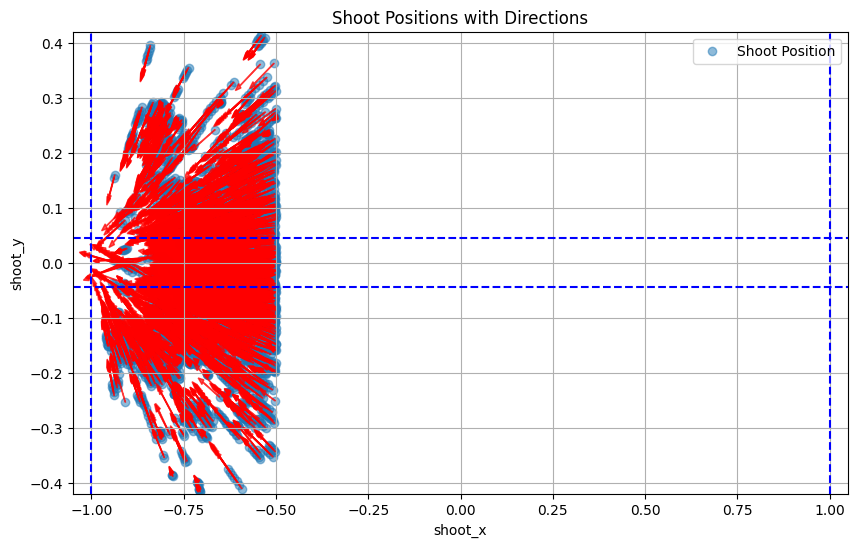

In [8]:
shoot_df = shoot_df.loc[shoot_df['shoot_x'] < 0]

scale_factor = 10 # 矢印の長さを調整する係数
plt.figure(figsize=(10, 6))

# 散布図のプロット
plt.scatter(shoot_df['shoot_x'], shoot_df['shoot_y'], alpha=0.5, label='Shoot Position')

# 各点に対して方向を示す矢印を追加
for i, row in shoot_df.iterrows():
    x = row['shoot_x']
    y = row['shoot_y']
    dx = row['shoot_direction_x']
    dy = row['shoot_direction_y']

    plt.arrow(x, y, dx * scale_factor, dy * scale_factor,
              head_width=0.01, head_length=0.015, fc='red', ec='red',
              length_includes_head=True, alpha=0.7)

# ゴールはx = -1,1 -0.044 < y < 0.044
plt.axvline(x=-1, color='blue', linestyle='--')
plt.axvline(x=1, color='blue', linestyle='--')
plt.axhline(y=0.044, color='blue', linestyle='--')
plt.axhline(y=-0.044, color='blue', linestyle='--')

plt.xlabel('shoot_x')
plt.ylabel('shoot_y')
plt.xlim(-1.05, 1.05)
plt.ylim(-0.42, 0.42)
plt.title('Shoot Positions with Directions')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [9]:
shoot_integrated_for_df = list()
for (n_iter, n_sub_iter), group in shoot_df.groupby(['n_iter', 'n_sub_iter']):
    shoot_integrated_for_df.append({
        'n_iter': n_iter,
        'n_sub_iter': n_sub_iter,
    })

shoot_integrated_df = pd.DataFrame(shoot_integrated_for_df)
shoot_integrated_df['is_shoot'] = True
shoot_integrated_df

,n_iter,n_sub_iter,is_shoot
0,1,13,True
1,1,28,True
2,1,42,True
3,1,48,True
4,1,52,True
...,...,...,...
974,100,67,True
975,100,77,True
976,100,83,True
977,100,96,True


In [10]:
result_df = result_df.merge(shoot_integrated_df, on=['n_iter', 'n_sub_iter'], how='left')
result_df['is_shoot'] = result_df['is_shoot'].fillna(False)
result_df

C:\Users\nakag\AppData\Local\Temp\ipykernel_13688\2421903654.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df['is_shoot'] = result_df['is_shoot'].fillna(False)


,frame_id,chance_team,winner,shoots,step_count,n_iter,n_sub_iter,is_win,is_shoot
0,1459164,Away,Draw,0,140,1,1,False,False
1,1459164,Away,Home,0,421,1,2,False,False
2,1459164,Away,Home,0,118,1,3,False,False
3,1459164,Away,Draw,0,207,1,4,False,False
4,1459164,Away,Draw,0,501,1,5,False,False
...,...,...,...,...,...,...,...,...,...
9995,1459164,Away,Draw,5,183,100,96,False,True
9996,1459164,Away,Draw,6,302,100,97,False,True
9997,1459164,Away,Draw,0,501,100,98,False,False
9998,1459164,Away,Draw,0,501,100,99,False,False


In [11]:
output_for_df = list()
for n_iter, group in result_df.groupby('n_iter'):
    win_ratio = group['is_win'].mean()
    shoot_ratio = group['is_shoot'].mean()
    output_for_df.append({
        'n_iter': n_iter,
        'shoot_ratio': shoot_ratio,
        'win_ratio': win_ratio,
    })
output_df = pd.DataFrame(output_for_df)
output_df['exam_id'] = 'initial'
output_df

,n_iter,shoot_ratio,win_ratio,exam_id
0,1,0.09,0.05,initial
1,2,0.11,0.06,initial
2,3,0.06,0.07,initial
3,4,0.12,0.07,initial
4,5,0.13,0.11,initial
...,...,...,...,...
95,96,0.04,0.04,initial
96,97,0.08,0.05,initial
97,98,0.15,0.06,initial
98,99,0.08,0.03,initial


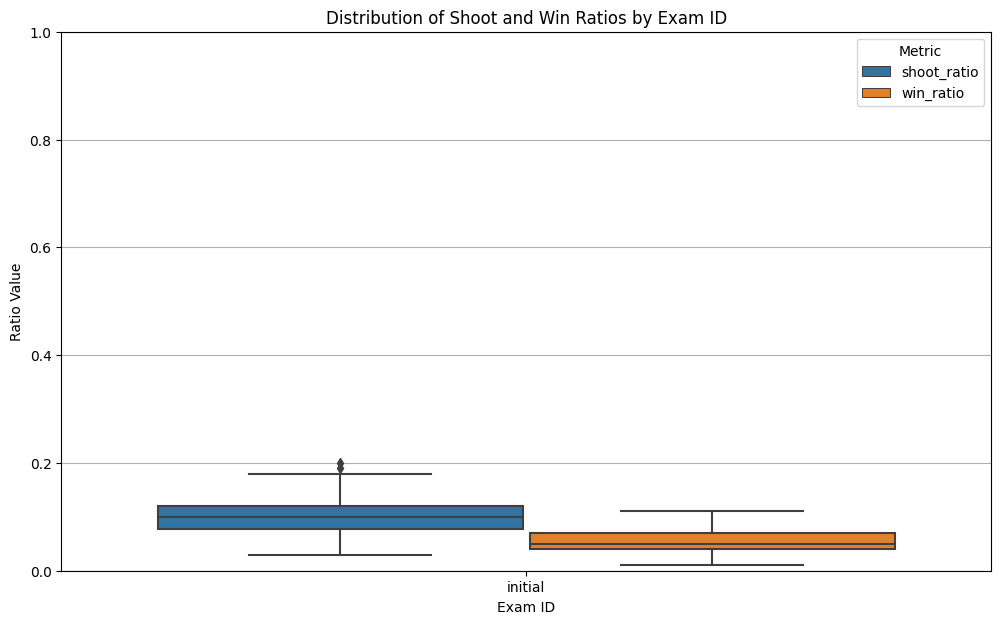

In [12]:
import seaborn as sns

df = output_df.copy()
df_melted = df.melt(id_vars=['n_iter', 'exam_id'], value_vars=['shoot_ratio', 'win_ratio'],
                    var_name='metric', value_name='value')

plt.figure(figsize=(12, 7))
sns.boxplot(x='exam_id', y='value', hue='metric', data=df_melted)
plt.title('Distribution of Shoot and Win Ratios by Exam ID')
plt.xlabel('Exam ID')
plt.ylabel('Ratio Value')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Metric')
# plt.tight_layout()
plt.show()

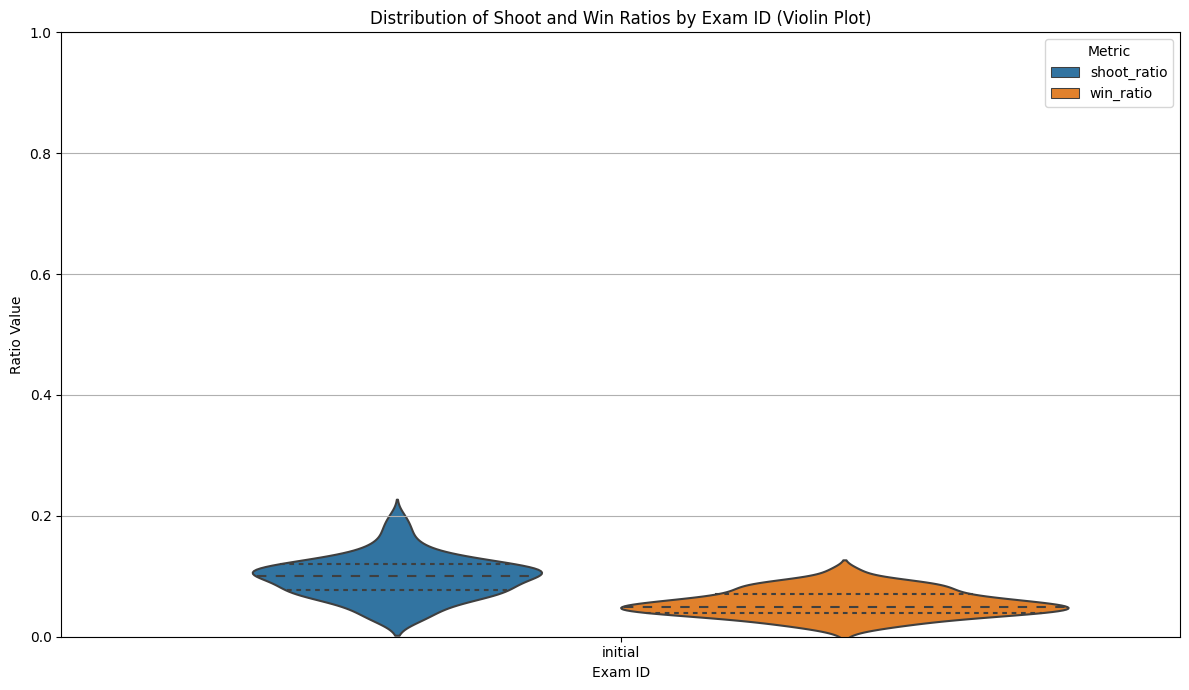

In [13]:
df_melted = df.melt(id_vars=['n_iter', 'exam_id'], value_vars=['shoot_ratio', 'win_ratio'],
                    var_name='metric', value_name='value')

plt.figure(figsize=(12, 7))

# sns.violinplotを使用してバイオリンプロットを作成
# split=Trueは、hueのカテゴリが2つである場合に、片側のバイオリンとして表示することでスペースを節約する
sns.violinplot(x='exam_id', y='value', hue='metric', data=df_melted, split=False, inner='quartile')

plt.title('Distribution of Shoot and Win Ratios by Exam ID (Violin Plot)')
plt.xlabel('Exam ID')
plt.ylabel('Ratio Value')
plt.ylim(0, 1) # Y軸の範囲を0から1に設定
plt.grid(axis='y')
plt.legend(title='Metric')
plt.tight_layout()